In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install librosa tensorflow scikit-learn matplotlib

In [3]:
import os
import librosa
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from multiprocessing import Pool, cpu_count
from tqdm import tqdm

# ravdess 폴더 내에 Actor_1~Actor 24 까지의 데이터가 존재
#  https://www.kaggle.com/datasets/uwrfkaggler/ravdess-emotional-speech-audio
data_path = '/content/drive/MyDrive/ravdess/'

# 감정 레이블 설정 - Kaggle 사이트에 분류된 Emotion 레이블 그대로 사용
emotion_labels_dict = {
    '01': 'neutral',
    '02': 'calm',
    '03': 'happy',
    '04': 'sad',
    '05': 'angry',
    '06': 'fearful',
    '07': 'disgust',
    '08': 'surprised'
}

def extract_features_2d(data_path):
    y, sr = librosa.load(data_path, sr=None)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
    mfccs = np.expand_dims(mfccs, axis=-1)  # Conv2D 입력 형태로 변환
    return y, sr, mfccs

# 파일을 처리하는 함수
def process_file(data_path):
    try:
        file_id = os.path.basename(data_path).split('-')
        emotion = emotion_labels_dict[file_id[2]] # 세번째 인덱스 감정 정보
        actor = int(file_id[6].split('.')[0]) # 마지막 인덱스 배우 정보
        gender = 'male' if actor % 2 != 0 else 'female' # 성별 분류해서 학습 진행 - 남자 여자의 목소리는 차이는 분명히 있다고 생각했음
        emotion_label = f'{gender}_{emotion}'
        y, sr, mfccs = extract_features_2d(data_path)
        return y, sr, mfccs, emotion_label, actor
    except Exception as e:
        return None

# 데이터와 레이블을 저장할 리스트 초기화
features = []
emotion_labels = []
actor_labels = []
waveforms = []
sample_rates = []

# 파일 불러오기
file_paths = []
for root, dirs, files in os.walk(data_path):
    for file in files:
        if file.endswith('.wav'):
            data_path = os.path.join(root, file)
            file_paths.append(data_path)

# librosa가 cpu를 기반으로 돌아가는 라이브러리라 GPU 연결시 처리가 오히려 너무 느려져서 병렬처리 찾아서 적용하였음
# tqdm은 얼마나 돌아가고 있는지를 시각화해줌. 0~100퍼
with Pool(cpu_count()) as pool:
    results = list(tqdm(pool.imap(process_file, file_paths), total=len(file_paths)))

# 병렬 처리 결고로 얻은 데이터 분리. 하나의 오디오 파일에서 값들을 뽑아냄
for result in results:
    if result is not None:
        y, sr, mfccs, emotion_label, actor_label = result
        waveforms.append(y)
        sample_rates.append(sr)
        features.append(mfccs)
        emotion_labels.append(emotion_label)
        actor_labels.append(actor_label)

# 모든 MFCC 배열을 동일한 길이로 패딩
max_length = max(feature.shape[1] for feature in features)
padded_features = np.array([np.pad(feature, ((0, 0), (0, max_length - feature.shape[1]), (0, 0)), mode='constant') for feature in features])

X = np.array(padded_features)
emotion_labels = np.array(emotion_labels)
actor_labels = np.array(actor_labels)

# male_happy, female_fearful 같은 데이터들을 OneHot 인코딩
emotion_encoder = LabelEncoder()
emotion_encoded = emotion_encoder.fit_transform(emotion_labels)
emotion_categorical = to_categorical(emotion_encoded)

actor_encoder = LabelEncoder()
actor_encoded = actor_encoder.fit_transform(actor_labels)
actor_categorical = to_categorical(actor_encoded)

# 학습용과 테스트용 데이터 분리
X_train, X_test, y_train_emotion, y_test_emotion, y_train_actor, y_test_actor = train_test_split(X, emotion_categorical, actor_categorical, test_size=0.2, random_state=42)

print(X_train.shape, X_test.shape)
print(y_train_emotion.shape, y_test_emotion.shape)
print(y_train_actor.shape, y_test_actor.shape)

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 1440/1440 [01:55<00:00, 12.43it/s]


(1152, 40, 495, 1) (288, 40, 495, 1)
(1152, 16) (288, 16)
(1152, 24) (288, 24)


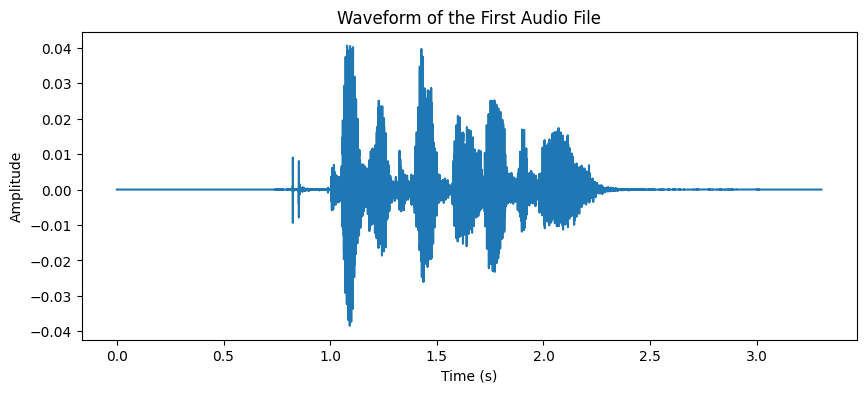

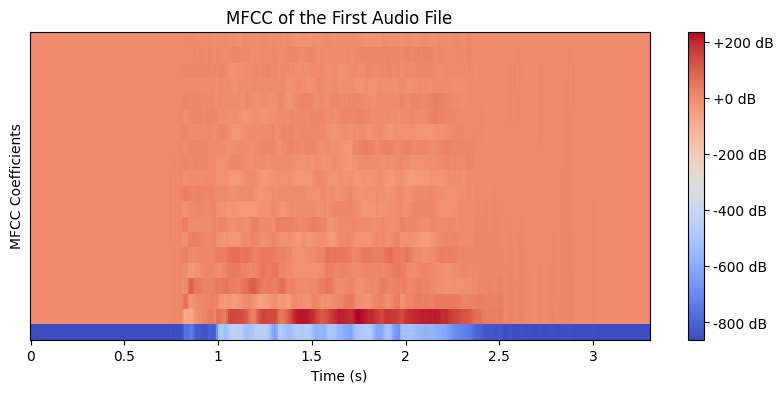

In [4]:
import matplotlib.pyplot as plt
import librosa.display

# 파형 시각화 함수
def plot_waveform(y, sr, title="Waveform"):
    plt.figure(figsize=(10, 4))
    plt.plot(np.linspace(0, len(y) / sr, len(y)), y)
    plt.title(title)
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.show()

# MFCC 시각화 함수
def plot_mfcc(y, sr, n_mfcc=20, title="MFCC"):
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(mfccs, sr=sr, x_axis='time')
    plt.colorbar(format='%+2.0f dB')
    plt.title(title)
    plt.xlabel("Time (s)")
    plt.ylabel("MFCC Coefficients")
    plt.show()

plot_waveform(waveforms[0], sample_rates[0], title="Waveform of the First Audio File")

plot_mfcc(waveforms[0], sample_rates[0], n_mfcc=20, title="MFCC of the First Audio File")

In [5]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

input_layer = Input(shape=(X_train.shape[1], X_train.shape[2], 1))

# Shared Layer
x = Conv2D(32, (3, 3), activation='relu')(input_layer)
x = MaxPooling2D((2, 2))(x)
x = Dropout(0.3)(x)
x = Conv2D(64, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Dropout(0.3)(x)
x = Conv2D(128, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Dropout(0.3)(x)
x = Flatten()(x)

# emotion 예측
emotion_output = Dense(128, activation='relu')(x)
emotion_output = Dropout(0.3)(emotion_output)
emotion_output = Dense(len(emotion_encoder.classes_), activation='softmax', name='emotion_output')(emotion_output)

# actor 예측
actor_output = Dense(128, activation='relu')(x)
actor_output = Dropout(0.3)(actor_output)
actor_output = Dense(len(actor_encoder.classes_), activation='softmax', name='actor_output')(actor_output)

model = Model(inputs=input_layer, outputs=[emotion_output, actor_output])

adam_optimizer = Adam(learning_rate=0.0005)

model.compile(optimizer=adam_optimizer,
              loss={'emotion_output': 'categorical_crossentropy', 'actor_output': 'categorical_crossentropy'},
              metrics={'emotion_output': 'accuracy', 'actor_output': 'accuracy'})

# Early Stopping 적용
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(X_train, {'emotion_output': y_train_emotion, 'actor_output': y_train_actor},
                    epochs=50,
                    validation_data=(X_test, {'emotion_output': y_test_emotion, 'actor_output': y_test_actor}),
                    callbacks=[early_stopping])

Epoch 1/50
36/36 [==============================] - 9s 27ms/step - loss: 12.4496 - emotion_output_loss: 7.0448 - actor_output_loss: 5.4047 - emotion_output_accuracy: 0.0920 - actor_output_accuracy: 0.0434 - val_loss: 5.8827 - val_emotion_output_loss: 2.7119 - val_actor_output_loss: 3.1708 - val_emotion_output_accuracy: 0.1319 - val_actor_output_accuracy: 0.0486
Epoch 2/50
36/36 [==============================] - 1s 16ms/step - loss: 5.8333 - emotion_output_loss: 2.6873 - actor_output_loss: 3.1460 - emotion_output_accuracy: 0.1233 - actor_output_accuracy: 0.0521 - val_loss: 5.6725 - val_emotion_output_loss: 2.5554 - val_actor_output_loss: 3.1171 - val_emotion_output_accuracy: 0.1910 - val_actor_output_accuracy: 0.1076
Epoch 3/50
36/36 [==============================] - 1s 16ms/step - loss: 5.5744 - emotion_output_loss: 2.5308 - actor_output_loss: 3.0436 - emotion_output_accuracy: 0.1502 - actor_output_accuracy: 0.0694 - val_loss: 5.3300 - val_emotion_output_loss: 2.3489 - val_actor_outp

In [6]:
# 모델 평가
evaluation_results = model.evaluate(X_test, {'emotion_output': y_test_emotion, 'actor_output': y_test_actor})
loss = evaluation_results[0]
emotion_output_loss = evaluation_results[1]
actor_output_loss = evaluation_results[2]
emotion_output_accuracy = evaluation_results[3]
actor_output_accuracy = evaluation_results[4]

print(f'Test Loss: {loss}')
print(f'Test Emotion Output Loss: {emotion_output_loss}')
print(f'Test Actor Output Loss: {actor_output_loss}')
print(f'Test Emotion Output Accuracy: {emotion_output_accuracy}')
print(f'Test Actor Output Accuracy: {actor_output_accuracy}')

# 예측 수행
predictions = model.predict(X_test)
predicted_emotions = np.argmax(predictions[0], axis=1)
predicted_actors = np.argmax(predictions[1], axis=1)
actual_emotions = np.argmax(y_test_emotion, axis=1)
actual_actors = np.argmax(y_test_actor, axis=1)

# 실제 레이블과 예측된 레이블 비교
for i in range(10):  # 10개만 출력
    actual_emotion = emotion_encoder.inverse_transform([actual_emotions[i]])[0]
    predicted_emotion = emotion_encoder.inverse_transform([predicted_emotions[i]])[0]
    actual_actor = actor_encoder.inverse_transform([actual_actors[i]])[0]
    predicted_actor = actor_encoder.inverse_transform([predicted_actors[i]])[0]
    print(f"Actual Emotion: {actual_emotion}, Predicted Emotion: {predicted_emotion}")
    print(f"Actual Actor: {actual_actor}, Predicted Actor: {predicted_actor}")
    print(f"=======================================================================")

9/9 [==============================] - 0s 6ms/step - loss: 2.5724 - emotion_output_loss: 1.3930 - actor_output_loss: 1.1794 - emotion_output_accuracy: 0.5625 - actor_output_accuracy: 0.6493
Test Loss: 2.5724165439605713
Test Emotion Output Loss: 1.3929728269577026
Test Actor Output Loss: 1.1794438362121582
Test Emotion Output Accuracy: 0.5625
Test Actor Output Accuracy: 0.6493055820465088
9/9 [==============================] - 0s 4ms/step
Actual Emotion: male_disgust, Predicted Emotion: male_disgust
Actual Actor: 3, Predicted Actor: 3
Actual Emotion: male_calm, Predicted Emotion: male_calm
Actual Actor: 11, Predicted Actor: 11
Actual Emotion: female_calm, Predicted Emotion: female_calm
Actual Actor: 10, Predicted Actor: 10
Actual Emotion: female_calm, Predicted Emotion: female_calm
Actual Actor: 2, Predicted Actor: 2
Actual Emotion: male_angry, Predicted Emotion: male_angry
Actual Actor: 11, Predicted Actor: 15
Actual Emotion: male_calm, Predicted Emotion: male_neutral
Actual Actor: 17